In [234]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics
%matplotlib inline


from sklearn.cluster import MiniBatchKMeans, KMeans

from experiment.algorithms.cluster_prep import xBins, clusterStats, bestClusters, saveLabels, saveResults

In [235]:
data = pd.read_pickle('sorted_households.pkl') # Read pickle file
# Read in only the sorted households, combine the dataframes with the sorted households features, perform clustering!!
# Include the other finished bins that completed feature extraction

df_50_150 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_50_150.csv',  header=[0, 1], index_col = 0)
df_150_400 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_150_400.csv',  header=[0, 1], index_col = 0)
df_400_600 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_400_600.csv',  header=[0, 1], index_col = 0)
df_600_1200 = pd.read_csv('data/features/FitFeatures/FitFeatures_600_1200.csv',  header=[0, 1], index_col = 0)
df_1200_2500 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
df_2500_4000 = pd.read_csv(r'data/features/FitFeatures/FitFeatures_2500_4000.csv',  header=[0, 1], index_col = 0)

# Select all filtered households 
df_50_150.loc[data['50_150']] 
df_150_400.loc[data['150_400']]
df_400_600.loc[data['400_600']] 
df_600_1200.loc[data['600_1200']] 
df_1200_2500.loc[data['1200_2500']] 

# Combine all the data
frame = [df_150_400,df_400_600,df_1200_2500,df_2500_4000]

df = pd.DataFrame()
df = df_50_150.append(frame)


In [142]:
# Remove outliers

# Find absolute value of z-score for each observation
z = np.abs(stats.zscore(df))

#only keep rows in dataframe with all z-scores less than absolute value of 3 
data_clean = df[(z<3).all(axis=1)]

In [143]:
data_clean

Morning                          Afternoon                        
             sigma1    sigma2 mu1         A1    sigma3    sigma4 mu2        A2
ProfileID                                                                     
18         1.095890  2.647059   4   1.586312  1.224490  2.222222  19  1.203960
20         1.315789  2.500000   5   1.829575  3.414634  1.333333  19  1.693074
23         1.538462  2.564103   7   1.383623  1.818182  1.333333  19  1.523198
24         0.008033  0.612245   5   0.232734  1.025641  1.632653  19  0.691852
25         2.089552  2.285714   8   1.265723  3.589744  2.857143  18  2.601424
...             ...       ...  ..        ...       ...       ...  ..       ...
12023836   1.282051  1.025641   6   4.871822  2.631579  2.500000  18  7.120582
12026241   3.636364  2.222222  10   3.895028  2.439024  1.632653  20  7.714916
12029032   2.173913  2.285714   8   5.347899  2.580645  2.352941  18  6.608913
1006685    0.987654  1.290323   7   2.930234  2.400000  2.926829  18  4.469430
1006691    5.185185  4.347826   7  10.250023  0.727273  1.481481  18  3.933140

[9370 rows x 8 columns]

### Visualize the data

In [94]:
# Transform dataframe to array
temp_df = df['Morning']
A = temp_df.iloc[:,:4].to_numpy()

In [104]:
# # Create Scatter Plot
# fig, ax = plt.subplots(figsize=(12,6))

# fig = plt.scatter(*A.T, s=50, linewidth=0, c='b', alpha=0.25)
# plt.xlim(0,20)

In [10]:
def kmeans(X, range_n_clusters, top_lbls=10, experiment_name = False):
    """
    This function applies the MiniBatchKmeans algorithm from sklearn on inputs X for range_n_clusters.
    If preprossing = True, X is normalised with sklearn.preprocessing.normalize()
    Returns cluster stats, cluster centroids and cluster labels.
    """
    # Transform dataframe to array
    temp_df = X['Morning']
    A = temp_df.iloc[:,:4].to_numpy()

    # Create dataframes for cluster results
    centroids = pd.DataFrame()
    stats = pd.DataFrame() 
    cluster_lbls = pd.DataFrame()

    dim = 0 #set dim to 0 to match SOM formating  
    cluster_lbls_dim = {}
    stats_dim = pd.DataFrame()
    
    for n_clust in range_n_clusters:
        
        clusterer = KMeans(n_clusters=n_clust, random_state=10)
                    
        #train clustering algorithm
        tic = time.time()        
        clusterer.fit(A)
        cluster_labels = clusterer.predict(A)
        toc = time.time()
        
        ## Calculate scores
        cluster_stats = clusterStats({}, n_clust, A, cluster_labels, 
                                         transform = None,
                                        tic = tic, toc = toc)        # preprocessing = preprocessing,
        cluster_centroids = clusterer.cluster_centers_ 
        
        eval_results, centroid_results = saveResults(experiment_name, cluster_stats,
                                                        cluster_centroids, dim)
        
        stats_dim = stats_dim.append(eval_results)
        centroids = centroids.append(centroid_results)

        cluster_lbls_dim[n_clust] = cluster_labels

    #outside n_clust loop
    best_clusters, best_stats = bestClusters(cluster_lbls_dim, stats_dim, top_lbls)
    cluster_lbls = pd.concat([cluster_lbls, best_clusters], axis=1)
    stats = pd.concat([stats, best_stats], axis=0)
    
    stats.reset_index(drop=True, inplace=True)


    saveLabels(cluster_lbls, stats)
    
    return stats, centroids, cluster_lbls        

# Choosing optimal number of clusters: Elbow Method

In [32]:
from sklearn.cluster import KMeans

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
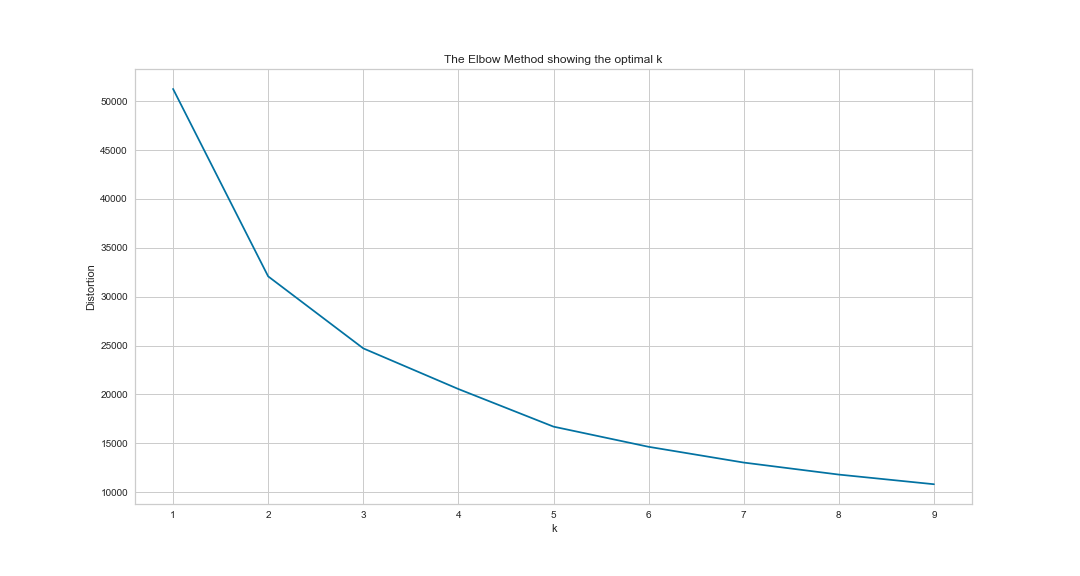

In [144]:
# Create dataset
temp_df = data_clean['Morning']
A = temp_df.iloc[:,[0,1,3]].to_numpy()

# Calculate distortions
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(A)
    distortions.append(kmeanModel.inertia_)

# Create Elbow Plot
plt.figure(figsize=(15,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [145]:
# Perform K-means clustering
kmeanModel = KMeans(n_clusters=5)
kmeanModel.fit(A)

KMeans(n_clusters=5)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
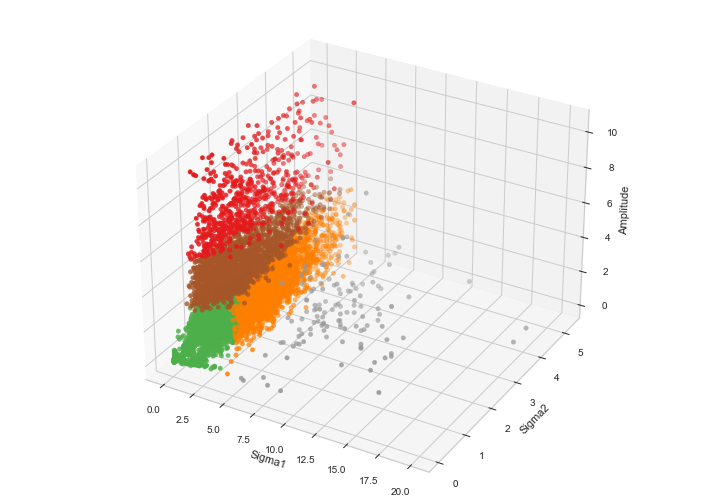

In [146]:
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D
# for creating a responsive plot
%matplotlib widget

X = pd.DataFrame()

# Plot Kmeans fit vs Actual
X['k_means'] = kmeanModel.predict(A)


# Create 3-D Scatter plot
## Creating Dataset
z = A[:,2]
y = A[:,1]
x = A[:,0]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = Axes3D(fig)
  

# Creating plot
ax.scatter(x, y, z, c=X['k_means'], cmap=plt.cm.Set1)
# setting title and labels
ax.set_title("3D plot")
ax.set_xlabel('Sigma1')
ax.set_ylabel('Sigma2')
ax.set_zlabel('Amplitude')

# show plot
plt.show()

# fig, axes = plt.subplots(1, 1, figsize=(16,8))
# # axes[0].scatter(df[0], df[1], c=df['target'])
# axes.scatter( c=X['k_means'], cmap=plt.cm.Set1)
# axes[0].set_title('Actual', fontsize=18)
# axes.set_title('K_Means', fontsize=18)

## Determine the goodness of fit of the clustering method: Silhouette Coefficient

In [27]:
from sklearn.metrics import silhouette_score
import seaborn as sns

<AxesSubplot:xlabel='0', ylabel='1'>

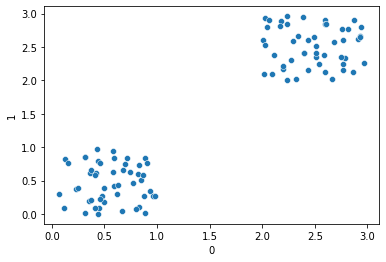

In [90]:
X= np.random.rand(50,2)
Y= 2 + np.random.rand(50,2)
Z= np.concatenate((X,Y))
Z=pd.DataFrame(Z) #converting into data frame for ease

sns.scatterplot(Z[0],Z[1])

In [156]:
# Create dataset
temp_df = data_clean['Morning']
A = temp_df.iloc[:,:3].to_numpy()


for i in range(2,10):
    KMean= KMeans(n_clusters=i)
    KMean.fit(A)
    label=KMean.predict(A)

    # Determine the Silhouette Score
    print(f'Silhouette Score(n={i}): {silhouette_score(A, label)}')

Silhouette Score(n=2): 0.4455567961791522
Silhouette Score(n=3): 0.4562656173358451
Silhouette Score(n=4): 0.2874627250862148
Silhouette Score(n=5): 0.320424198374339
Silhouette Score(n=6): 0.2983489105039951
Silhouette Score(n=7): 0.29418699974747925
Silhouette Score(n=8): 0.28276057370351737
Silhouette Score(n=9): 0.2639377533234188


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
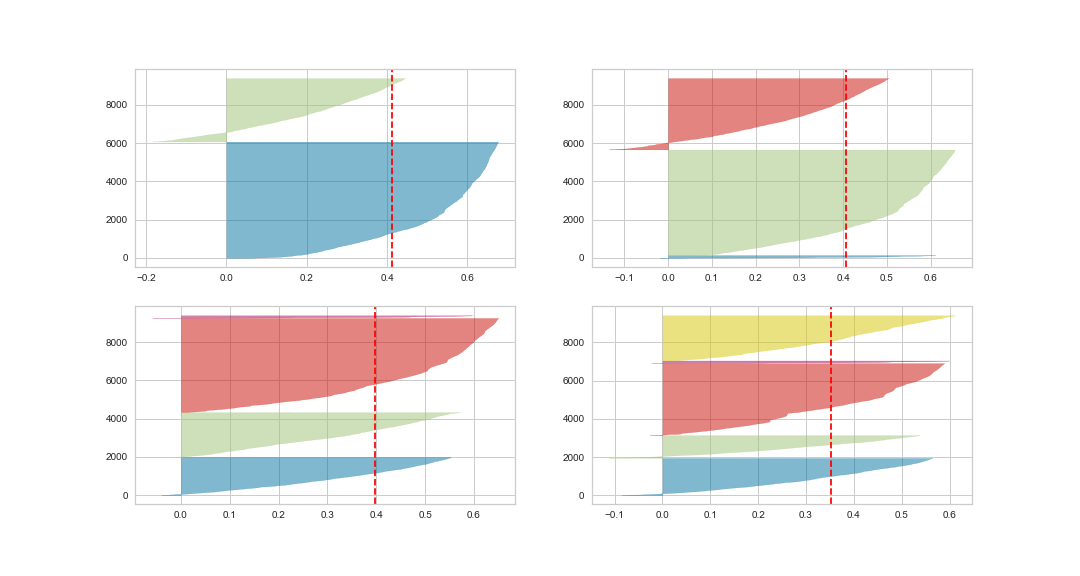

In [158]:
from yellowbrick.cluster import SilhouetteVisualizer

# Create dataset
temp_df = data_clean['Morning']
A = temp_df.iloc[:,:2].to_numpy()
 
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(A) 

# DBSCAN clustering

In [236]:
# Import it!
from dbscan2 import dbscan2
from sklearn.datasets import make_moons

In [268]:
# Create dataset
# df = pd.read_csv('FitFeatures_1200_2500.csv',  header=[0, 1], index_col = 0)
temp_df = data_clean['Morning']
A = temp_df.iloc[:,0:2].to_numpy()

In [277]:
dbscan_df = pd.DataFrame(columns = ['eps', 'n_clusters', 'Silhouette Coefficient'])

for eps in np.arange(0.1,1,0.05):
    min_samples = 3

    # instantiating DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    # fitting model
    model = dbscan.fit(A)
    labels = model.labels_

    # identify core samples
    core_samples = np.zeros_like(labels, dtype=bool)
    core_samples[dbscan.core_sample_indices_] = True
    # print(core_samples)

    # declare the number of clusters
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) 
    list_dbscan = [[eps,n_clusters_, metrics.silhouette_score(A, labels)]]
    dbscan_df = dbscan_df.append(pd.DataFrame(list_dbscan, columns =  ['eps', 'n_clusters', 'Silhouette Coefficient']), ignore_index = True)        

    # print(f'Number of clusters = {n_clusters_}')
    # print(f"eps = {eps}, min_smaples = {min_samples}")
    # print("Silhoette Coefficient: %0.3f" % metrics.silhouette_score(A, labels))

In [278]:
dbscan_df[dbscan_df['Silhouette Coefficient'] == dbscan_df[dbscan_df['n_clusters'] >= 3]['Silhouette Coefficient'].max()]

,eps,n_clusters,Silhouette Coefficient
15,0.85,3,0.823442


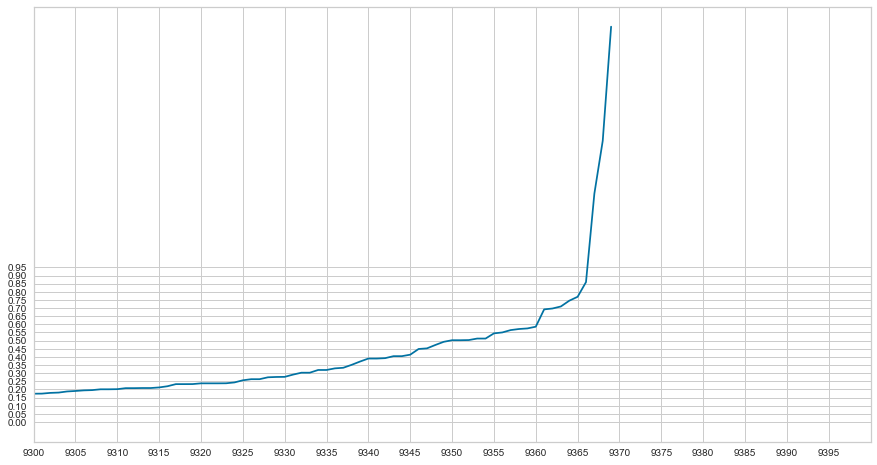

In [272]:
from sklearn.neighbors import NearestNeighbors # importing the library
neighb = NearestNeighbors(n_neighbors=2) # creating an object of the NearestNeighbors class
nbrs=neighb.fit(A) # fitting the data to the object
distances,indices=nbrs.kneighbors(A) # finding the nearest neighbours
%matplotlib inline
 
fig = plt.figure(figsize=(15,8))

# Sort and plot the distances results
distances = np.sort(distances, axis = 0) # sorting the distances
distances = distances[:, 1] # taking the second column of the sorted distances
plt.rcParams['figure.figsize'] = (5,3) # setting the figure size
plt.xlim(9300,9400)
plt.xticks(np.arange(9300,9400,5))
plt.yticks(np.arange(0,1,0.05))
plt.plot(distances) # plotting the distances
plt.show() # showing the plot

# Gowers Distance

In [282]:
from sklearn.neighbors import DistanceMetric
import gower

In [285]:
morning_DF = data_clean['Morning']
morning_DF

,sigma1,sigma2,mu1,A1
ProfileID,,,,
18,1.095890,2.647059,4,1.586312
20,1.315789,2.500000,5,1.829575
23,1.538462,2.564103,7,1.383623
24,0.008033,0.612245,5,0.232734
25,2.089552,2.285714,8,1.265723
...,...,...,...,...
12023836,1.282051,1.025641,6,4.871822
12026241,3.636364,2.222222,10,3.895028
12029032,2.173913,2.285714,8,5.347899


In [287]:
gower_array = gower.gower_matrix(morning_DF)

In [288]:
gower_array

array([[0.        , 0.04684689, 0.10809317, ..., 0.24556512, 0.19214138,
        0.4331043 ],
       [0.04684689, 0.        , 0.07899768, ..., 0.19871822, 0.15079308,
        0.4003396 ],
       [0.10809317, 0.07899768, 0.        , ..., 0.14714798, 0.10479075,
        0.34263098],
       ...,
       [0.24556512, 0.19871822, 0.14714798, ..., 0.        , 0.15144777,
        0.28464115],
       [0.19214138, 0.15079308, 0.10479075, ..., 0.15144777, 0.        ,
        0.37358892],
       [0.4331043 , 0.4003396 , 0.34263098, ..., 0.28464115, 0.37358892,
        0.        ]], dtype=float32)